# K-fold

In [1]:
from sklearn import datasets
boston = datasets.load_boston()

In [25]:
X = boston.data
y = boston.target

In [16]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    print("TRAIN -", len(train_index))
    print("TEST -", len(test_index))

TRAIN - 455
TEST - 51
TRAIN - 455
TEST - 51
TRAIN - 455
TEST - 51
TRAIN - 455
TEST - 51
TRAIN - 455
TEST - 51
TRAIN - 455
TEST - 51
TRAIN - 456
TEST - 50
TRAIN - 456
TEST - 50
TRAIN - 456
TEST - 50
TRAIN - 456
TEST - 50


In [17]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=10)
lasso_regressor = Lasso()
ridge_regressor = Ridge()

lasso_mse = []
ridge_mse = []

for train_index, test_index in kf.split(X):
    lasso_regressor.fit(X[train_index], y[train_index])  # 넣어준 인덱스 값만 남김
    ridge_regressor.fit(X[train_index], y[train_index])
    
    lasso_mse.append(mean_squared_error(y[test_index], lasso_regressor.predict(X[test_index])))
    ridge_mse.append(mean_squared_error(y[test_index], ridge_regressor.predict(X[test_index])))
    
sum(lasso_mse) / 10, sum(ridge_mse) / 10

(34.464084588302306, 34.07824620925927)

# K-fold Cross Validation

- 학습 데이터를 K번 나눠서 Test와 Train을 실시-> Test의 평균값을 사용
- cross_val_score 함수로, 한번에 해결가능
- sklearn은 pipeline 등을 위해 "High is better"(큰 값일수록 성능이 좋은 것이다)로 처리 -> MSE를 Negative로 변환 
- 이로인해 RMSE를 지원하지 않음
-https://scikit-learn.org/stable/modules/model_evaluation.html 

In [27]:
from sklearn.model_selection import cross_val_score
import numpy as np 

lasso_regressor = Lasso(warm_start=False)
ridge_regressor = Ridge()

lasso_scores = cross_val_score(lasso_regressor, X, y, cv=10, scoring='neg_mean_squared_error')
#cv는 cross validation의 약자로 k-fold 시행 횟수이다.
ridge_scores= cross_val_score(ridge_regressor, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(lasso_scores), np.mean(ridge_scores)

(-34.46408458830231, -34.07824620925927)

# Leave One Out(LOO)

- simple cross validation -> k = data size
- 한번에 한 개의 데이터만 Test set으로 사용함 -> 총 k번 iteration

In [29]:
from sklearn.model_selection import LeaveOneOut

test = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(test):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [35]:
loo = LeaveOneOut()
    
lasso_scores = cross_val_score(lasso_regressor, X, y, cv=loo, scoring='neg_mean_squared_error')
ridge_scores= cross_val_score(ridge_regressor, X, y, cv=loo, scoring='neg_mean_squared_error')
np.mean(lasso_scores), np.mean(ridge_scores)

(-28.409266762049334, -23.862836317209958)

In [37]:
lasso_scores = cross_val_score(
    lasso_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
ridge_scores= cross_val_score(
    ridge_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
np.mean(lasso_scores), np.mean(ridge_scores)

(-34.46408458830231, -34.07824620925927)

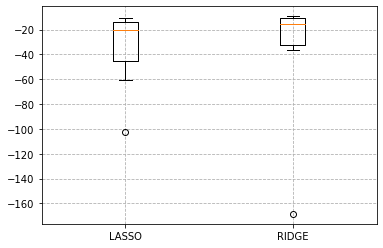

In [38]:
import matplotlib.pyplot as plt
labels=["LASSO", "RIDGE"]
plt.boxplot((lasso_scores, ridge_scores), labels=labels)
plt.grid(linestyle="--")
plt.show()

# Validation set for parameter turning

- Validation set의 많은 이유중 하나가 Hyper parameter turning
- Number of iterations(SGD), Number of branch (Tree-based) etc.
- Validation set의 성능으로 최적의 parameter를 찾음
- Validation set 결과와 Training set 결과의 차이가 벌어지면 overfitting

In [54]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

std = StandardScaler()
std.fit(X)
X_scaled = std.transform(X)

eta0 = 0.0001
max_iter = 100

In [55]:
from sklearn.model_selection import train_test_split


X_train_dataset, X_test, y_train_dataset, y_test = train_test_split(
            X_scaled,y, test_size=0.2, random_state=42)

sgd_regressor = SGDRegressor(
    eta0=eta0, max_iter=max_iter, warm_start=True, learning_rate="constant")

rmse_val_score = []
rmse_train_score = []
model_list = []

X_train, X_val, y_train, y_val = train_test_split(
    X_train_dataset,y_train_dataset, test_size=0.2, random_state=42)
sgd_regressor.fit(X_train,y_train)

# kf = KFold(n_splits=100, shuffle=True)
# for train_index, test_index in kf.split(X_train_dataset):

for i in range(300):

    y_pred = sgd_regressor.predict(X_train)
    y_true = y_train
    rmse_train_score.append(rmse(y_pred, y_true))

    y_pred = sgd_regressor.predict(X_val)
    y_true = y_val
    rmse_val_score.append(rmse(y_pred, y_true))
    model_list.append(sgd_regressor) # 인스턴스를 담고 
 
    coef = sgd_regressor.coef_.copy()
    intercept = sgd_regressor.intercept_.copy()

    sgd_regressor = SGDRegressor(
        eta0=eta0, max_iter=max_iter, warm_start=True, learning_rate="constant")
    
    sgd_regressor.fit(X_train,y_train, coef_init=coef, intercept_init=intercept)

C:\Users\1004\anaconda3\envs\human\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\1004\anaconda3\envs\human\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


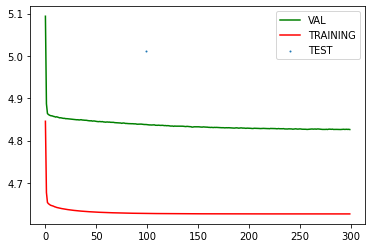

In [56]:
plt.plot(range(len(rmse_val_score)), rmse_val_score,  c="g", label="VAL")
plt.plot(range(len(rmse_train_score)), rmse_train_score,  c="r", label="TRAINING")
plt.scatter(99, rmse(y_test,sgd_regressor.predict(X_test)), s=1, label="TEST")
plt.legend()
plt.show()

In [57]:
np.argsort(rmse_val_score)

array([299, 290, 277, 285, 289, 287, 288, 283, 257, 275, 291, 273, 294,
       297, 284, 272, 286, 292, 258, 295, 274, 281, 298, 255, 276, 256,
       296, 293, 271, 253, 278, 254, 266, 252, 280, 259, 243, 263, 282,
       279, 270, 248, 260, 269, 244, 264, 247, 261, 249, 238, 251, 265,
       267, 262, 268, 236, 235, 242, 237, 245, 241, 250, 240, 239, 246,
       227, 233, 232, 228, 230, 220, 231, 234, 225, 224, 226, 218, 219,
       216, 229, 211, 212, 217, 204, 203, 222, 223, 213, 221, 215, 210,
       209, 214, 208, 206, 207, 202, 197, 205, 200, 196, 190, 199, 201,
       198, 194, 185, 186, 195, 191, 189, 184, 193, 183, 192, 187, 176,
       188, 182, 181, 179, 177, 178, 180, 173, 175, 174, 172, 170, 171,
       165, 164, 169, 162, 167, 168, 166, 163, 161, 160, 159, 158, 157,
       154, 144, 145, 153, 156, 152, 155, 148, 149, 151, 150, 146, 147,
       143, 142, 141, 138, 140, 137, 139, 126, 136, 133, 134, 135, 131,
       128, 132, 130, 129, 123, 124, 125, 127, 122, 119, 121, 12

In [58]:
rmse(y_test,sgd_regressor.predict(X_test))

5.011628307560952

In [63]:
rmse(y_test,model_list[0].predict(X_test))

5.406873370591457

In [60]:
rmse(y_test,model_list[299].predict(X_test))

5.011020927012706

# ETC...

- ReapatedKFold - 중복이 포함된 K-Fold 생성
- LeavePOut - 한번에 P개를 뽑음 (Not LOO for one data)
- ShuffleSplit - 독립적인(중복되는) 데이터 sampling
- StatifiedKFold - Y값 비율에 따라 뽑음
- GroupKFold - 그룹별로 데이터를 sampling